In [73]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import dask.dataframe as dd
import warnings
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from collections import Counter
warnings.filterwarnings("ignore")
from dask_jobqueue import SLURMCluster
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from os.path import join
import os
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
import random
sns.set_style("darkgrid")

In [74]:
def plot_cluster_dist(data):
    plt.figure(figsize=(12,6))
    
    counts = Counter(data['cluster'])
    percent_counts = [x / sum(counts.values()) * 100 for x in counts.values()]
    sns.barplot(list(counts.keys()), percent_counts, palette='deep')
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Percent of Storms', fontsize=14)
    #plt.savefig('/glade/scratch/cbecker/HWT_figures/cluster_dist.png', bbox_inches='tight')
    return counts

def plot_prob_dist(data):
    
    sns.displot(data=data, x='cluster_prob', hue='cluster', multiple='stack', palette='dark', kind='kde', aspect=2)
    plt.xlabel('Cluster Probability', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    #plt.savefig('/glade/scratch/cbecker/HWT_figures/cluster_prob_dist.png', bbox_inches='tight')
    plt.figure(figsize=(12,6))

def plot_prob_cdf(data):
    
    kwargs = {'cumulative': True}
    sns.distplot(data['cluster_prob'], hist_kws=kwargs, kde_kws=kwargs)
    plt.xlabel('Cluster Probability', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    #plt.savefig('/glade/scratch/cbecker/HWT_figures/cluster_prob_cdf.png', bbox_inches='tight')

### Clustering of Neuron Activations
Note: Spectral clustering does not scale well. Using a larger amount of samples will significantly increase computational time. GMM scales well and can use all storms. 

In [76]:
data_path = '/glade/scratch/dgagne/NSC_data/track_data_nsc_3km_REFL_COM_ws_nc/'
neuron_activations = '/glade/scratch/cbecker/HWT_out/refl_uh_6_class/neuron_activations_refl_dn6_class_train.csv'
df = pd.read_csv(neuron_activations)
n_samps = 20000
df_samp = df.sample(n_samps)

# Get neuron activations for training
X_gmm = df.iloc[:, -6:]
X_spectral = df_samp.iloc[:, -6:]

# Number of clusters to create for each method
n_clusters = 7

#storage for dfs with cluster information
cluster_dfs = {}

### Gaussian Mixture Model 
* gm_labels: cluster labels for all storms
* gm_proba: probabilities of each storm by component/cluster
* Counts of labels

In [77]:
%%time
gm = GaussianMixture(n_components=n_clusters, covariance_type='full', max_iter=100, tol=1e-3, n_init=5, verbose=1, init_params='kmeans').fit(X_gmm)
gm_labels = gm.predict(X_gmm)
gm_proba = gm.predict_proba(X_gmm)

# add clusters to Neuron activations
df['cluster'] = gm_labels
df['cluster_prob'] = gm_proba.max(axis=1)
cluster_dfs['GMM'] = df

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
CPU times: user 4min 1s, sys: 3min 29s, total: 7min 31s
Wall time: 7min 31s


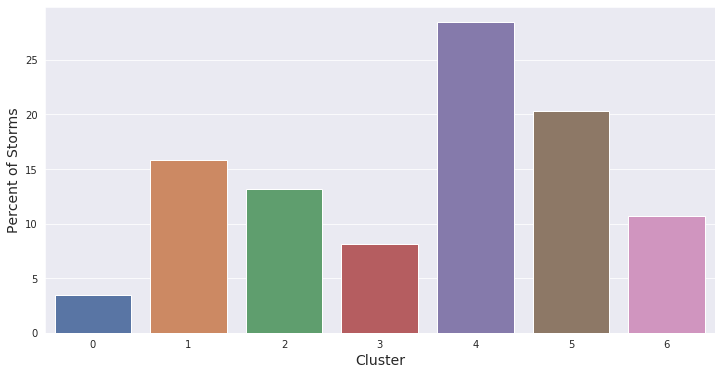

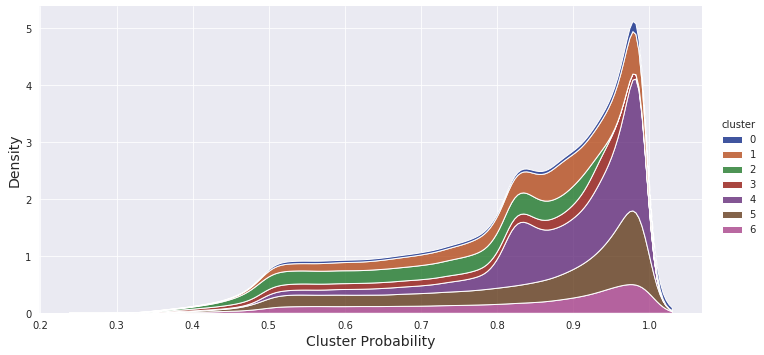

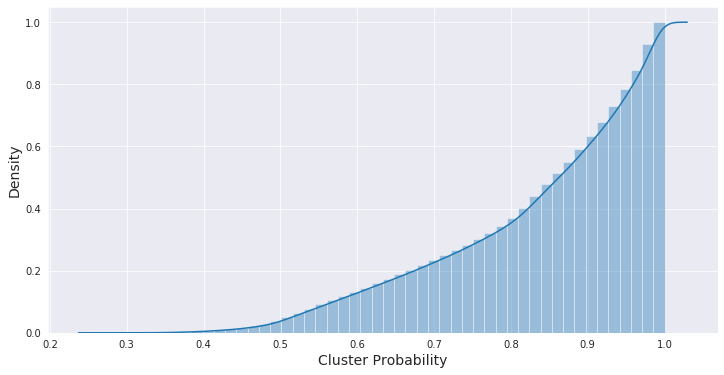

In [78]:
plot_cluster_dist(df)
plot_prob_dist(df)
plot_prob_cdf(df)

### Spectral Clustering
* spectral_labels: cluster labels 
* Count of labels

In [87]:
%%time
#spectral = SpectralClustering(n_clusters=n_clusters, n_jobs=-1)
#spectral_labels = spectral.fit(X_spectral)

df_samp['cluster'] = spectral_labels.labels_
cluster_dfs['Spectral'] = df_samp

CPU times: user 2.08 ms, sys: 38 µs, total: 2.12 ms
Wall time: 88.1 ms


Counter({3: 8138, 0: 4300, 2: 2166, 5: 4343, 1: 779, 4: 210, 6: 64})

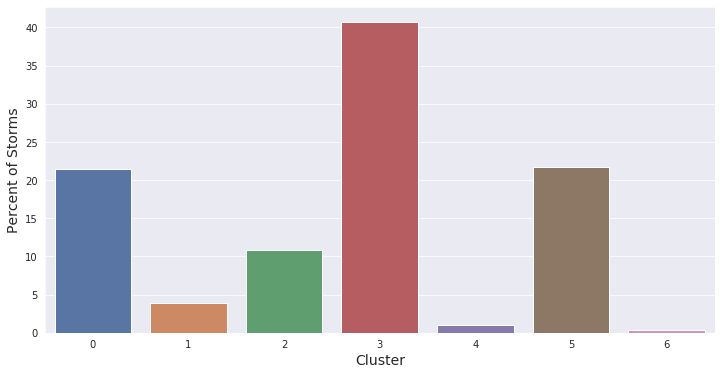

In [90]:
plot_cluster_dist(df_samp)

#### Plotting options:
* **cluster_method**: 'GMM' or 'Spectral'
* **n_storms**: Must be an even square (4, 9, 16, 25)
* **gmm_storm_probabilities**: Which probability storm to plot. 'highest', 'lowest', 'random'
* **save_figures**: Boolean
* **save_out_path**: Base path to save figures (if True)
* **seed**: Random seed for sampling storms

In [91]:
cluster_method = 'GMM'
n_storms = 25
gmm_storm_probabilities = 'highest'
save_figures = False
save_out_path = '/glade/scratch/cbecker/HWT_figures/'
seed = 88

CPU times: user 6min 49s, sys: 23.5 s, total: 7min 13s
Wall time: 8min 56s


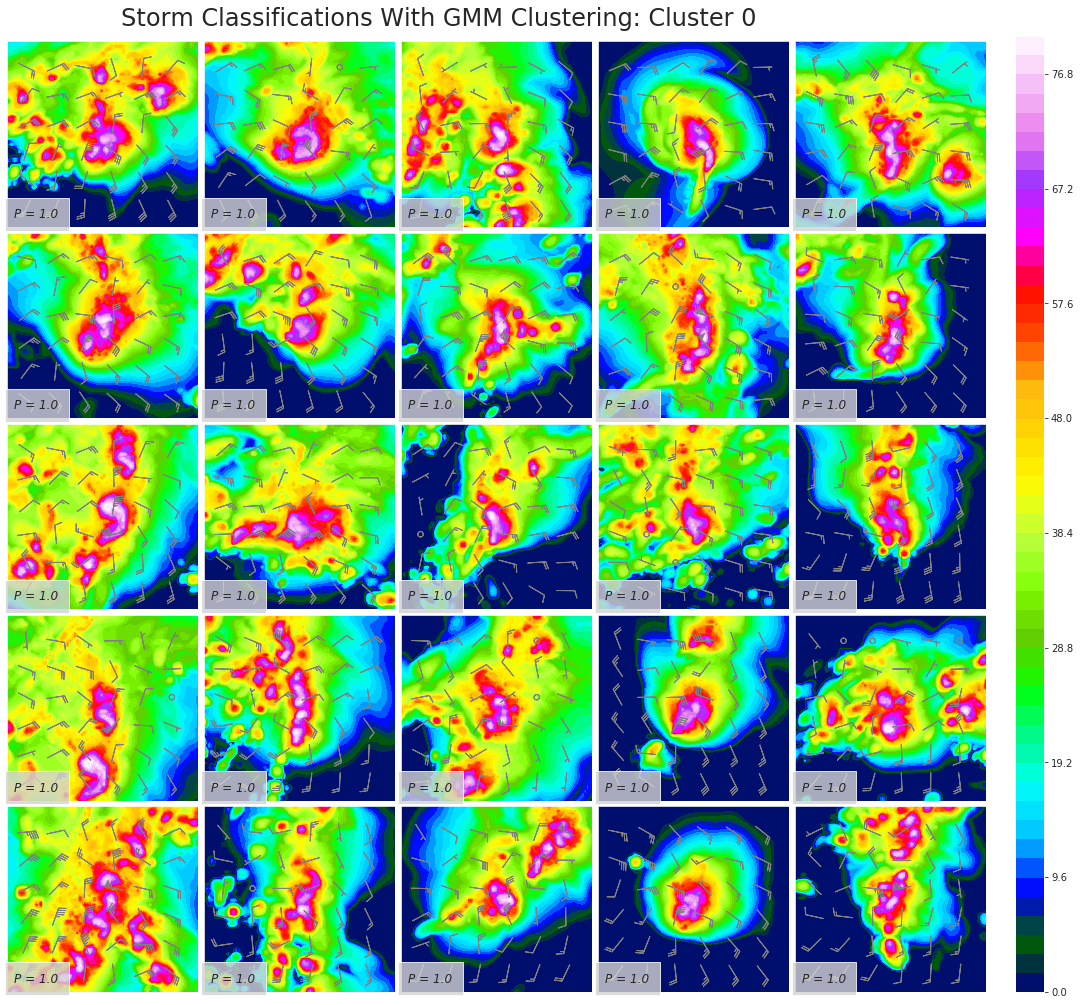

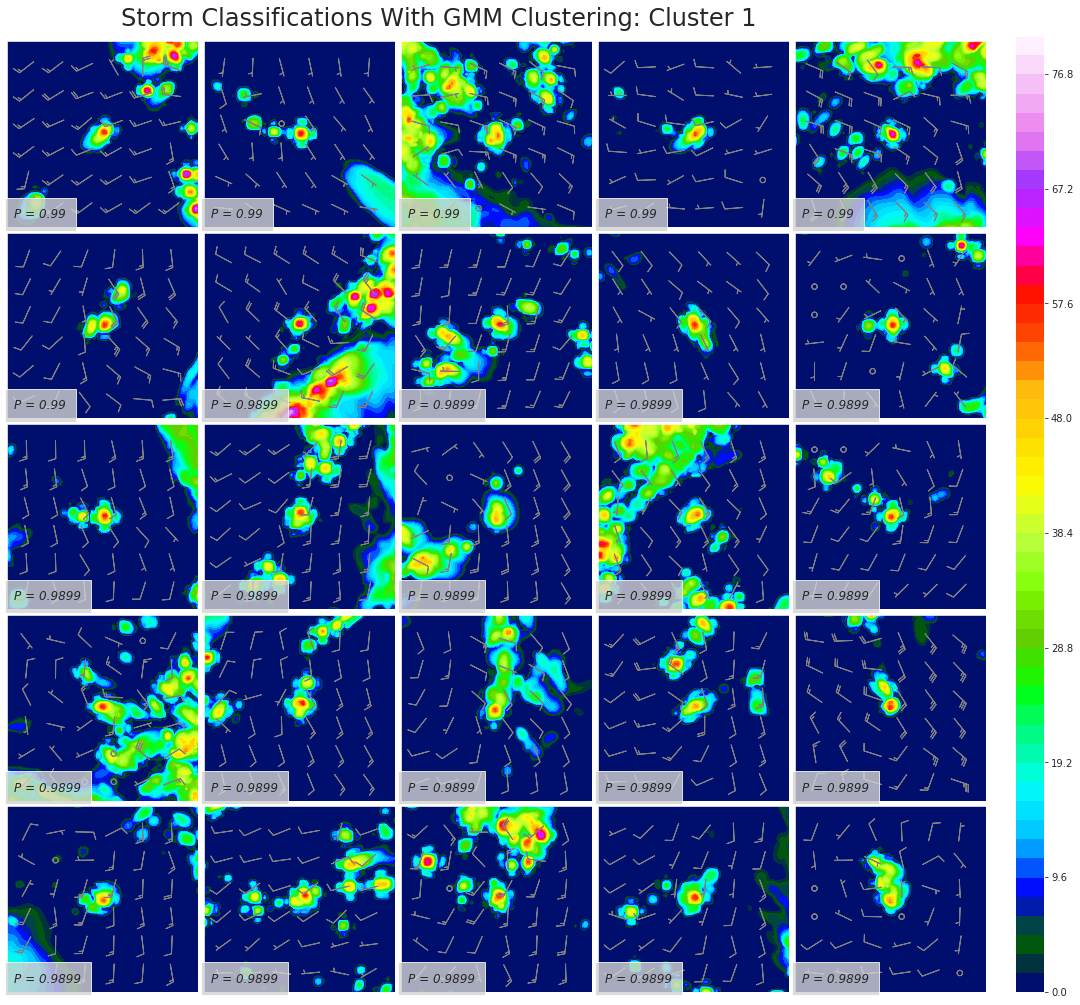

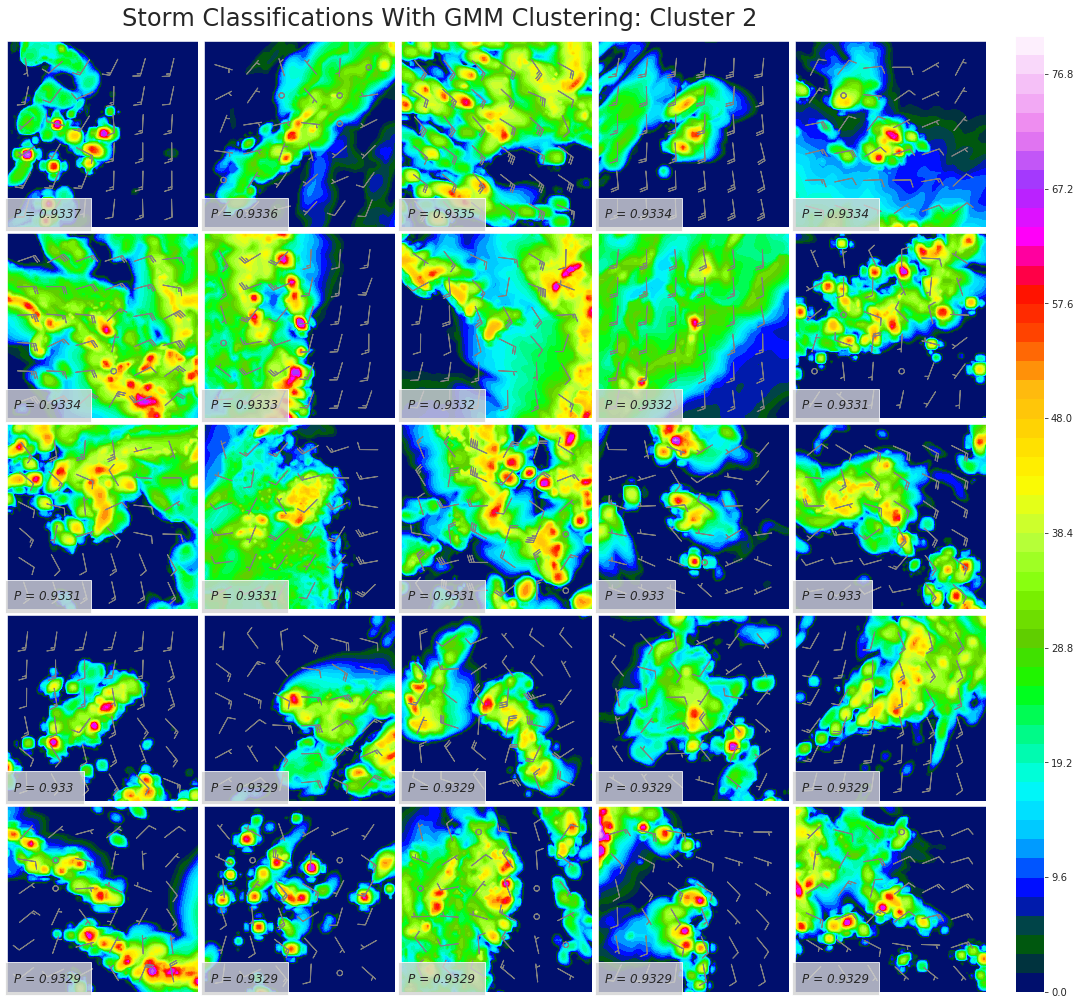

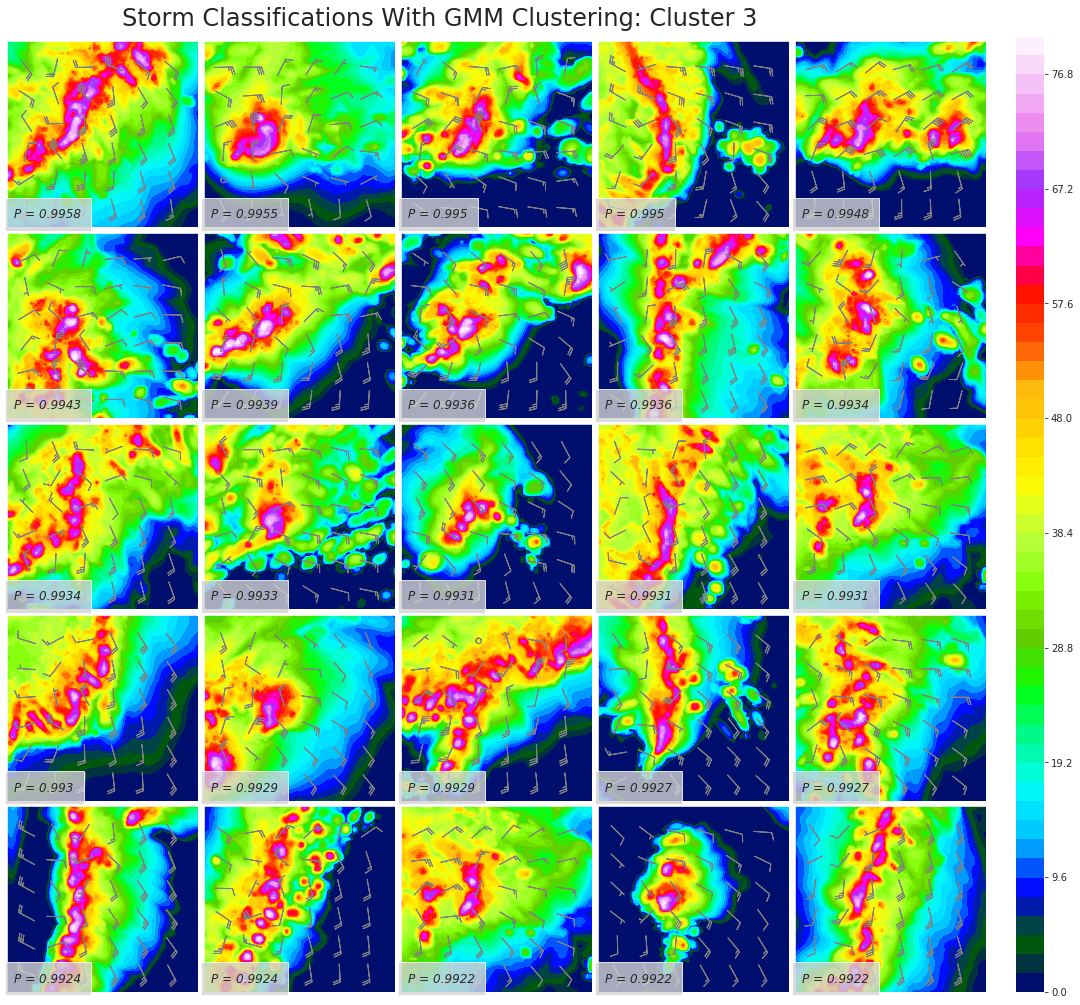

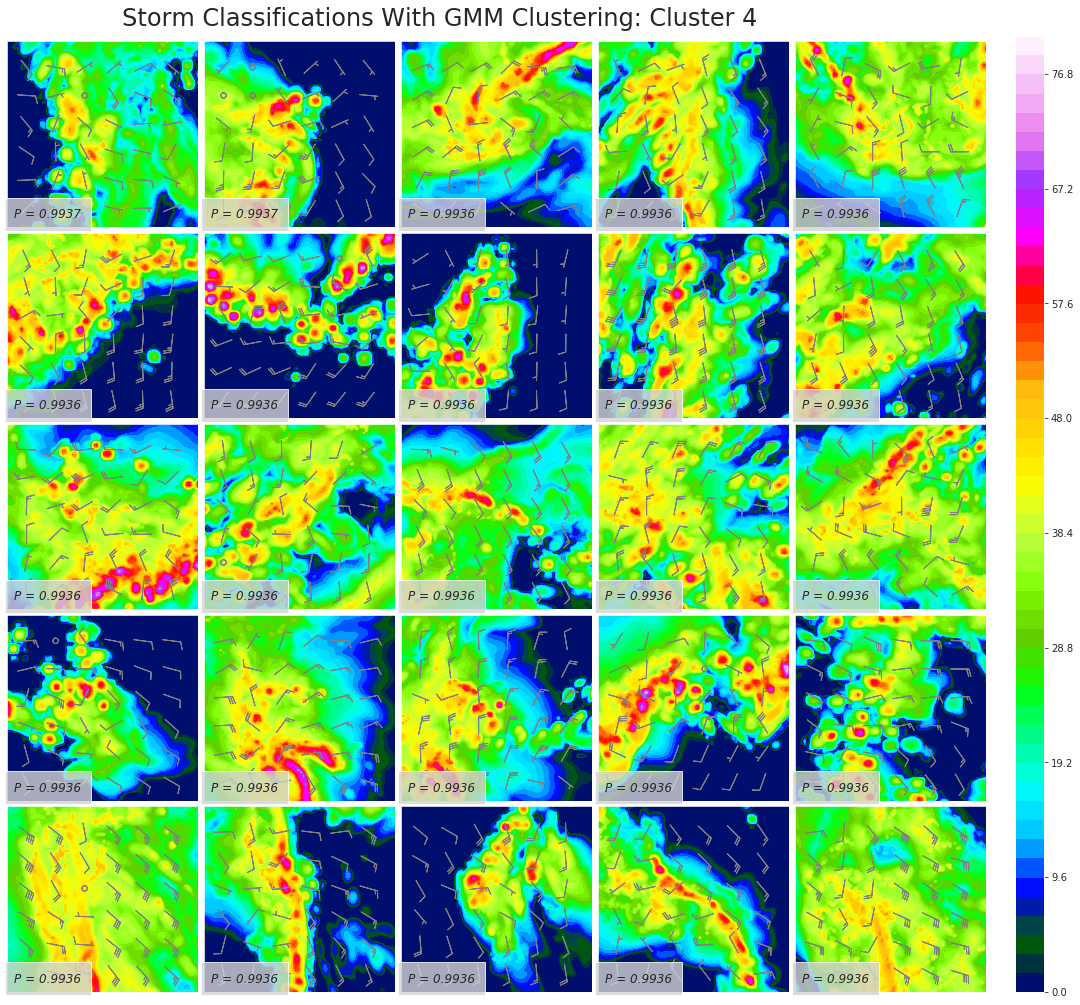

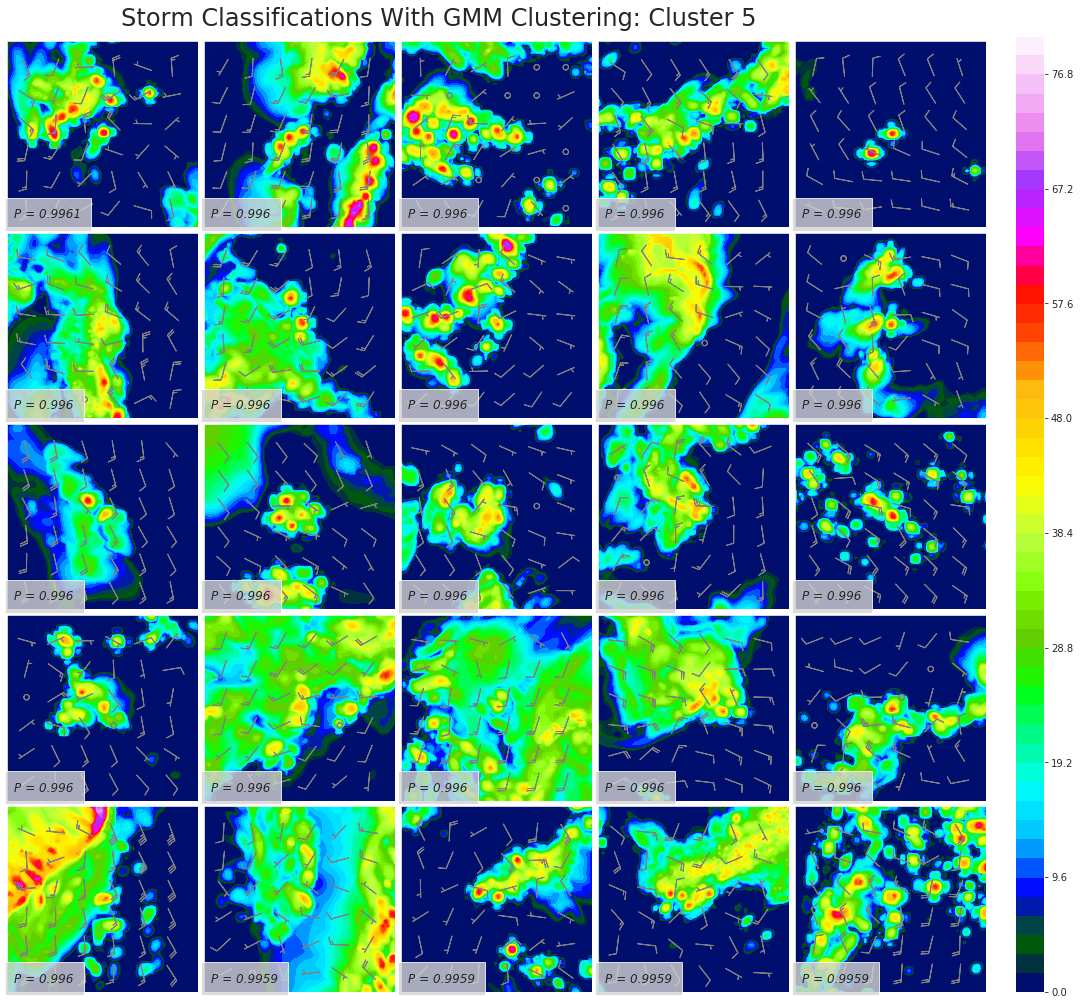

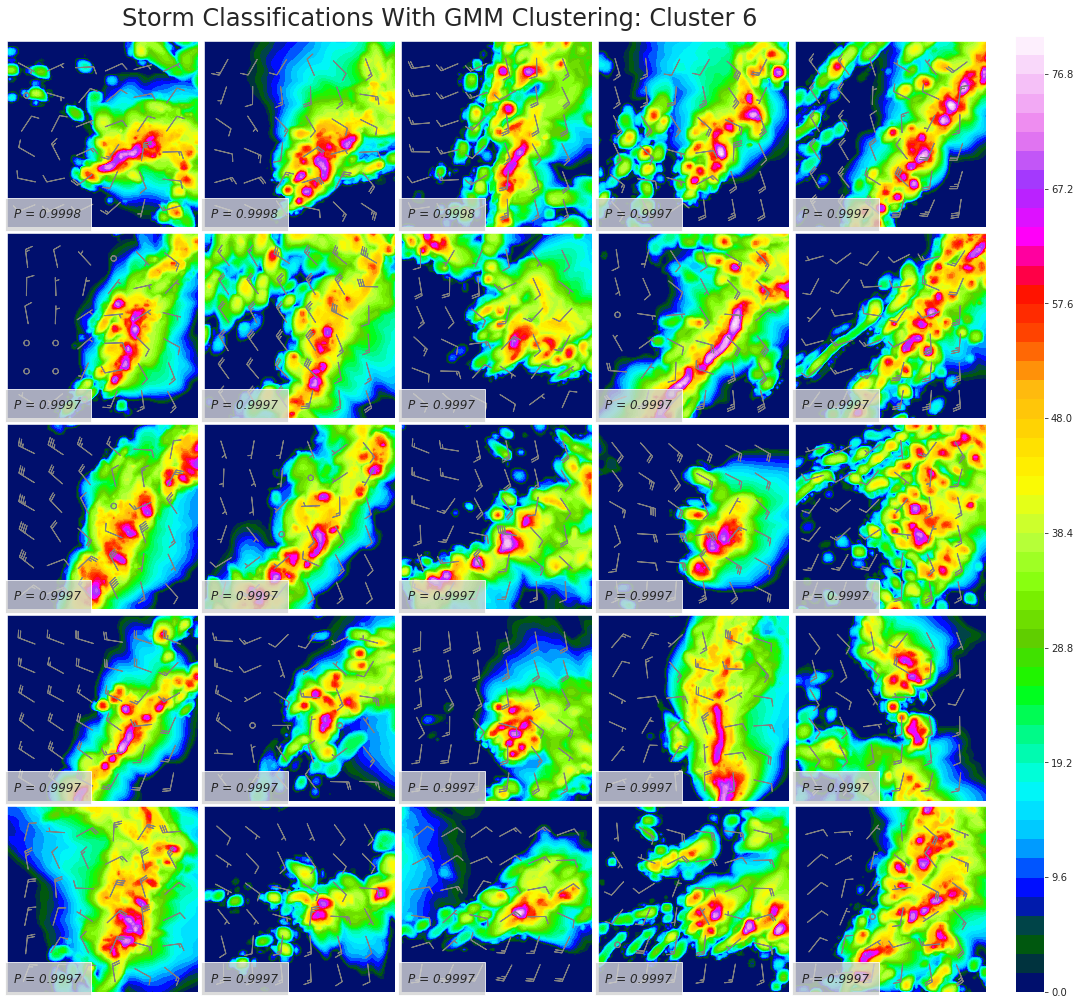

In [96]:
%%time
ms_mph = 2.237 # conversion from m/s to mph

file_dates = sorted(pd.to_datetime(cluster_dfs[cluster_method]['run_date'].unique()))
file_paths = sorted([join(data_path, f'NCARSTORM_{x.strftime("%Y%m%d")}-0000_d01_model_patches.nc') for x in file_dates])
ds = xr.open_mfdataset(file_paths)
wind_slice = (slice(8, None, 12), slice(8, None, 12))
x_mesh, y_mesh = np.meshgrid(range(len(ds['row'])), range(len(ds['col'])))

cluster_df = cluster_dfs[cluster_method]

if len(cluster_dfs[cluster_method]) != len(ds['p']):
    raise AssertionError('Number of storms in neuron activation file and storm patches do not match.')
    
for cluster in range(cluster_df['cluster'].nunique()):
    
    if cluster_method == 'Spectral':
        sub = cluster_df[cluster_df['cluster'] == cluster].sample(n_storms, random_state=seed)
    elif cluster_method == 'GMM':
        if gmm_storm_probabilities == 'highest':
            sub = cluster_df[cluster_df['cluster'] == cluster].sort_values(['cluster_prob'], ascending=False)[:n_storms]
        elif gmm_storm_probabilities == 'lowest':
            sub = cluster_df[cluster_df['cluster'] == cluster].sort_values(['cluster_prob'], ascending=True)[:n_storms]
        elif gmm_storm_probabilities == 'random':
            sub = cluster_df[cluster_df['cluster'] == cluster].sample(n_storms, random_state=seed)
            
    storm_idxs = sub.index.values
    x = ds[['REFL_COM_curr', 'U10_curr', 'V10_curr']].isel(p=storm_idxs)
    
    fig, axes = plt.subplots(int(np.sqrt(n_storms)), int(np.sqrt(n_storms)) , figsize=(16, 16), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.03, hspace=0.03)

    for i, ax in enumerate(axes.ravel()):
        
        im = ax.contourf(x['REFL_COM_curr'][i], levels=np.linspace(0, 80, 51), vmin=0, vmax=80, cmap='gist_ncar')
        ax.barbs(x_mesh[wind_slice], y_mesh[wind_slice],  x['U10_curr'][i][wind_slice] * ms_mph, x['V10_curr'][i][wind_slice] * ms_mph, color='grey', pivot='middle', length=6)
        
        if cluster_method == 'GMM':
            ax.text(3, 4, f"P = {np.round(sub.iloc[i, :]['cluster_prob'], 4)}", style='italic', fontsize=12, bbox={'facecolor': 'lightgrey', 'alpha': 0.8, 'pad': 10})
            
        plt.subplots_adjust(right=0.975)
        cbar_ax = fig.add_axes([1, 0.125, 0.025, 0.83])
        fig.colorbar(im, cbar_ax)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        
    plt.suptitle(f'Storm Classifications With {cluster_method} Clustering: Cluster {cluster}', fontsize=24)
    plt.subplots_adjust(top=0.95)
    
    if save_figures:
        if cluster_method == 'Spectral':
            plt.savefig(join(save_out_path, f'{cluster_method}_{n_clusters}_{cluster}.png'), bbox_inches='tight')
        else:
            plt.savefig(join(save_out_path, f'{cluster_method}_n{n_clusters}_{cluster}_{gmm_storm_probabilities}_refl_25.png'), bbox_inches='tight')